In [6]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using OffsetArrays: no_offset_view
using CairoMakie.Colors

[ Info: Created a front state with Riₘᵢₙ = 0.40176515151238734, Roₘᵢₙ = -0.8010762192478551, Roₘₐₓ = 0.8106258719831098


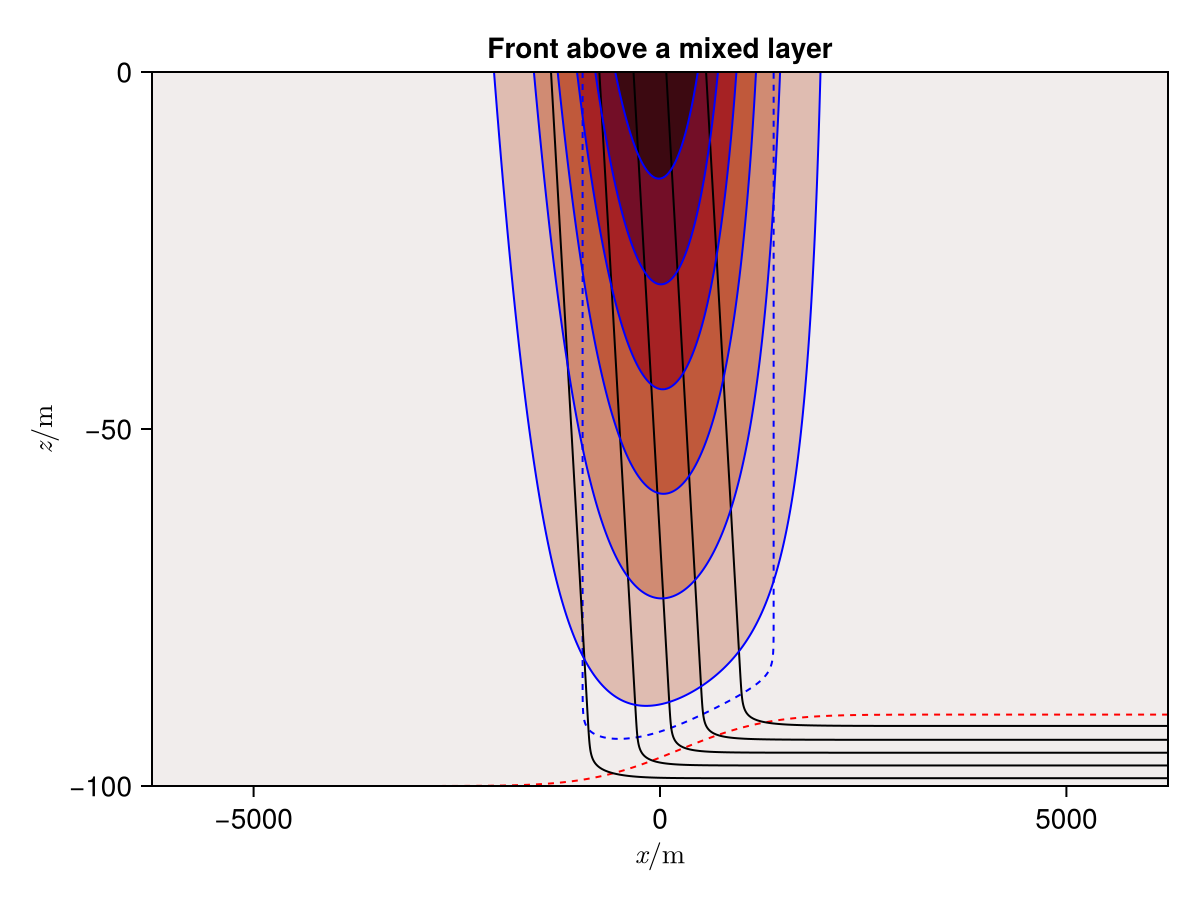

In [5]:
include("../src-fronts/parameters.jl")
include("../src-fronts/base_state.jl")
g(x) = log(1 + exp(x))
sp = create_simulation_parameters(; Ri=0.4, Ro=0.8, Q=100)
(; xs, zs, u, v, w, b) = get_base_state(sp)

ζ = (circshift(v, (-1, 0)) - circshift(v, (1, 0))) ./ (circshift(xs, -1) - circshift(xs, 1))
N² = zeros(size(b))
N²[:, 2:end] = (b[:, 2:end] - b[:, 1:end-1]) ./ (reshape(zs[2:end], 1, 499) - reshape(zs[1:end-1], 1, 499))
S = zeros(size(v))
S[:, 2:end] = (v[:, 2:end] - v[:, 1:end-1]) ./ (reshape(zs[2:end], 1, 499) - reshape(zs[1:end-1], 1, 499))
M² = (circshift(b, (-1, 0)) - circshift(b, (1, 0))) ./ (circshift(xs, -1) - circshift(xs, 1))
M²[1, :] .= M²[2, :]
M²[end, :] .= M²[end-1, :]

q = (ζ .+ sp.f) .* N² .- S .* M²

v_approx(x, z) = let h(x) = sp.H * γ(x/sp.ℓ, sp.δ)
    let x = x + sp.a*sp.H/2
        z₀(x, n) = n <= 0 ? 0 : h(x + sp.a*z₀(x, n-1))
    (1-sp.ε) * sp.N₀² * (h(x+sp.a*z) - h(x+sp.a*z₀(x, 5))) / (sp.f * sp.a)
    end
end

Ri = N² ./ S.^2
Ro = ζ ./ sp.f

Riₘᵢₙ = minimum(Ri[:, 2:end])
Roₘᵢₙ = minimum(Ro)
Roₘₐₓ = maximum(Ro)

@info "Created a front state with Riₘᵢₙ = $Riₘᵢₙ, Roₘᵢₙ = $Roₘᵢₙ, Roₘₐₓ = $Roₘₐₓ"

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{m}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(xs[1], xs[end], -sp.H, 0))
h(x, z) = z - sp.H * γ(x/sp.ℓ, 0.1)

let a = [v_approx(x, z) for x in xs, z in zs]
    contourf!(ax, xs, zs, a; levels=range(-maximum(abs, a), maximum(abs, a), 14), colormap=:balance)
end
#heatmap!(ax, xs, zs, q; colormap=:balance, colorrange=(-sp.f * sp.N₀²/10, sp.f * sp.N₀²/10))
contour!(ax, xs, zs, q; levels=[0], color=:blue, linestyle=:dash)
contour!(ax, xs, zs, (x, z)->h(x + sp.a * (z+sp.H/2), z); color=:red, levels=[0], linestyle=:dash)
contour!(ax, xs, zs, b; color=:black)
let a = v
    contour!(ax, xs, zs, a; levels=range(-maximum(abs, a), maximum(abs, a), 14), color=:blue)
end
fig

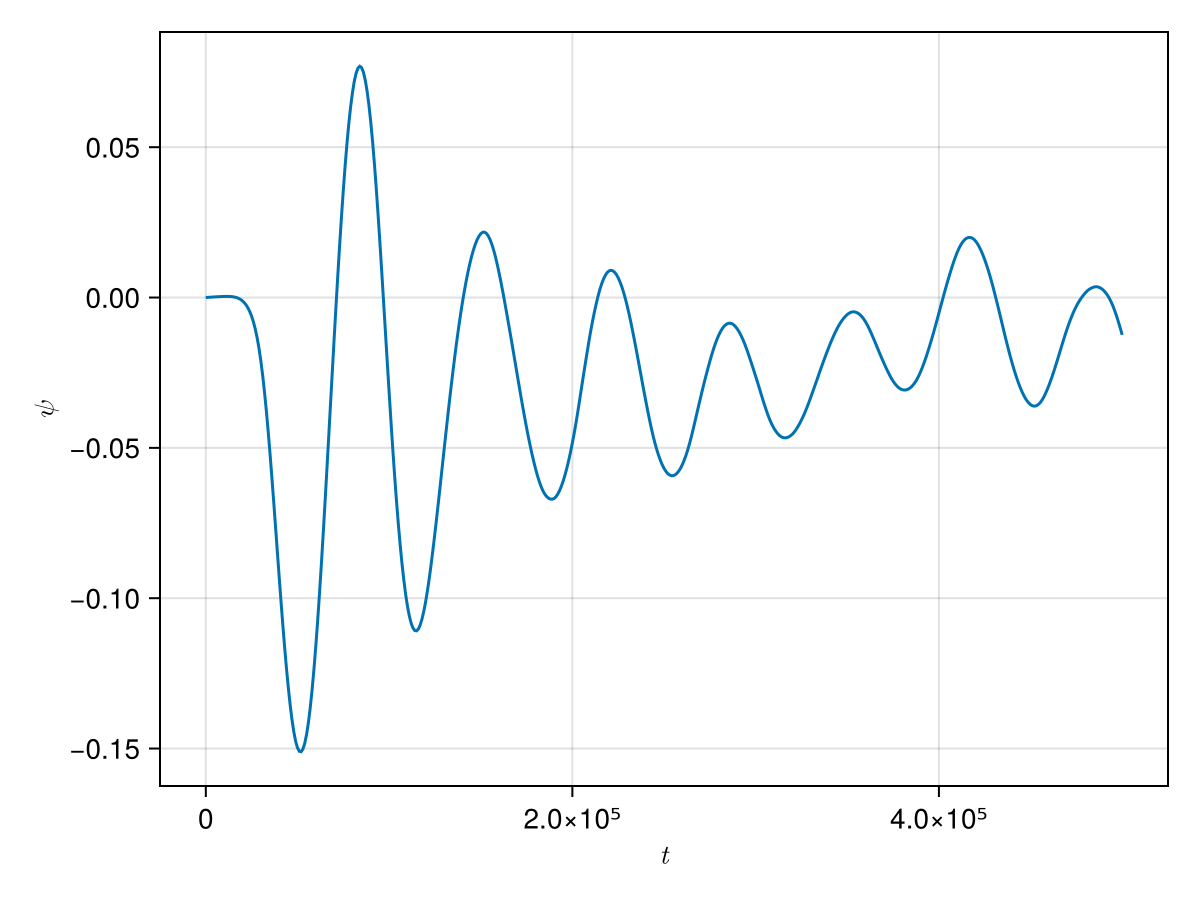

In [23]:
# Print simulation outputs
# Get a state of simulation
foldername = "../../scratch/Project/NIechoes"

sp = jldopen("$foldername/parameters.jld2") do file
    file["simulation"]
end
filename = "$foldername/DFM.jld2"
ts, ψ = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    ψ = map(frames) do frame 
        mean(file["timeseries/ψ/$frame"][4:end-3, 1, 4:end-3])
    end
    ts, ψ
    end;
fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"t", ylabel=L"\psi")
lines!(ax, ts, ψ)

fig

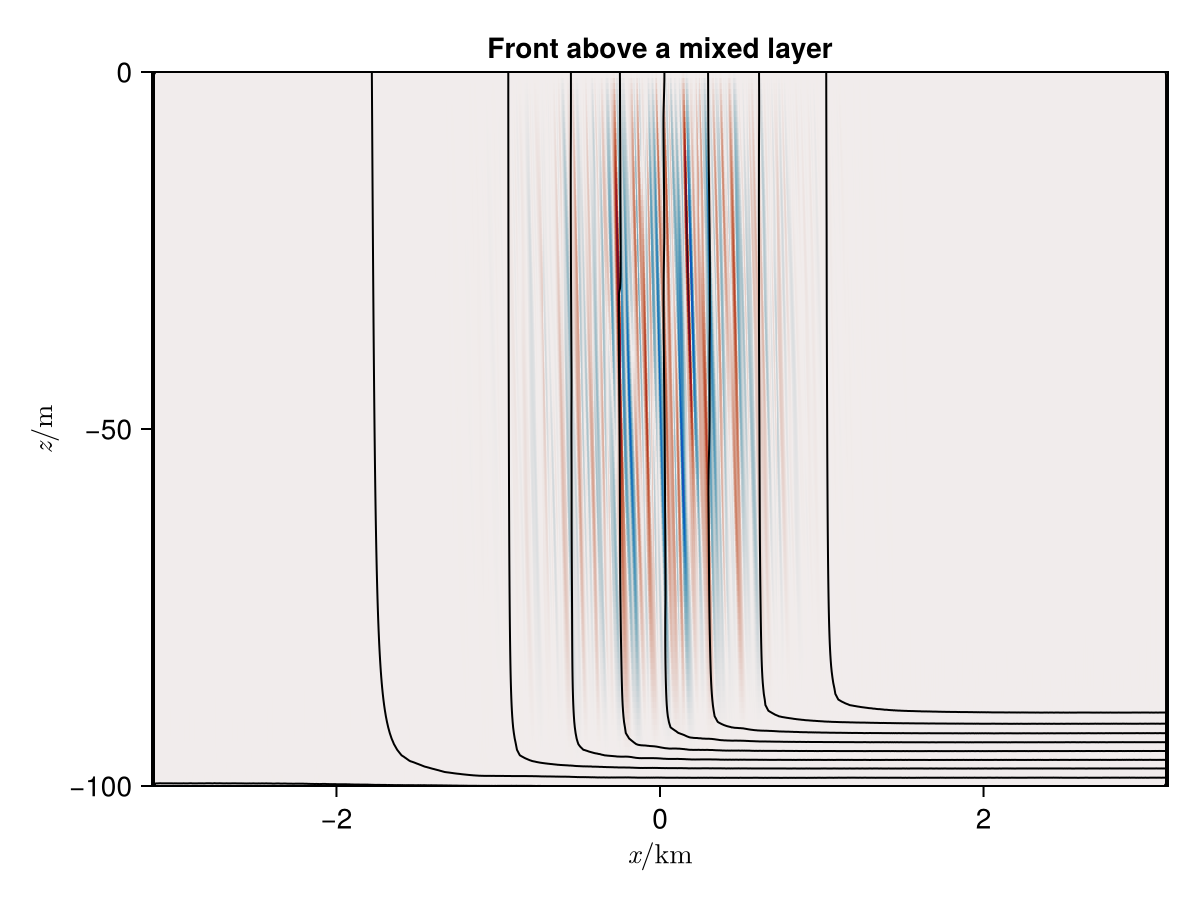

In [25]:
# Print simulation outputs
# Get a state of simulation
n = 41
foldername = "../../scratch/Project/NIechoes"

sp = jldopen("$foldername/parameters.jld2") do file
    file["simulation"]
end
filename = "$foldername/initialisation.jld2"
t, xs, ys, zs, u, v, w, b, φ = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"]
    ys = file["grid/yᵃᶜᵃ"]
    zs = file["grid/zᵃᵃᶜ"]
    u = (file["timeseries/u/$frame"][1:end-1, :, :] .+ file["timeseries/u/$frame"][2:end, :, :]) ./ 2
    v = (circshift(file["timeseries/v/$frame"], (0, -1, 0)) .+ circshift(file["timeseries/v/$frame"], (0, 1, 0))) ./ 2
    w = (file["timeseries/w/$frame"][:, :, 1:end-1] .+ file["timeseries/w/$frame"][:, :, 2:end]) ./ 2
    b = file["timeseries/b/$frame"]
    φ = file["timeseries/φ/$frame"]
    ts[n], xs, ys, zs, u, v, w, b, φ
    end;
fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(xs[1]/1000, xs[end]/1000, -sp.H, 0))
#field = mean((v .- mean(v; dims=2)) .* (w .- mean(w; dims=2)); dims=2)[:, 1, :]
#ψ = mean(cumsum(u; dims=3) * (zs[2]-zs[1]); dims=2)[:, 1, :]
b_levels = range(minimum(mean(b[4:end-3, :, 4:end-3]; dims=2)), maximum(mean(b[4:end-3, :, 4:end-3]; dims=2)), 10)
#field = field - imfilter(field, gaussian((10, 0)))
field = mean(w; dims=2)[:, 1, :]# .- mean(w; dims=2)[:, 1, :]
#field = imfilter(field, gaussian((10, 0)))
#field = circshift(mean(φ; dims=2)[:, 1, :], (-1, 0)) .- circshift(mean(φ; dims=2)[:, 1, :], (1, 0))
heatmap!(ax, xs / 1000, zs, field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, zs, mean(b; dims=2)[:, 1, :]; color=:black, levels=b_levels)
#contour!(ax, xs / 1000, zs, mean(v; dims=2)[:, 1, :]; color=:blue, levels=5)
#contour!(ax, xs / 1000, zs, ψ; colormap=:balance, colorrange=(-maximum(abs, ψ), maximum(abs, ψ)), levels=3)

fig

Mean RMS 0.00020657217335400671
Mean max 0.0015791007994217755
Fluc RMS 0.000217129113520907
Fluc max 0.0021140528736407977


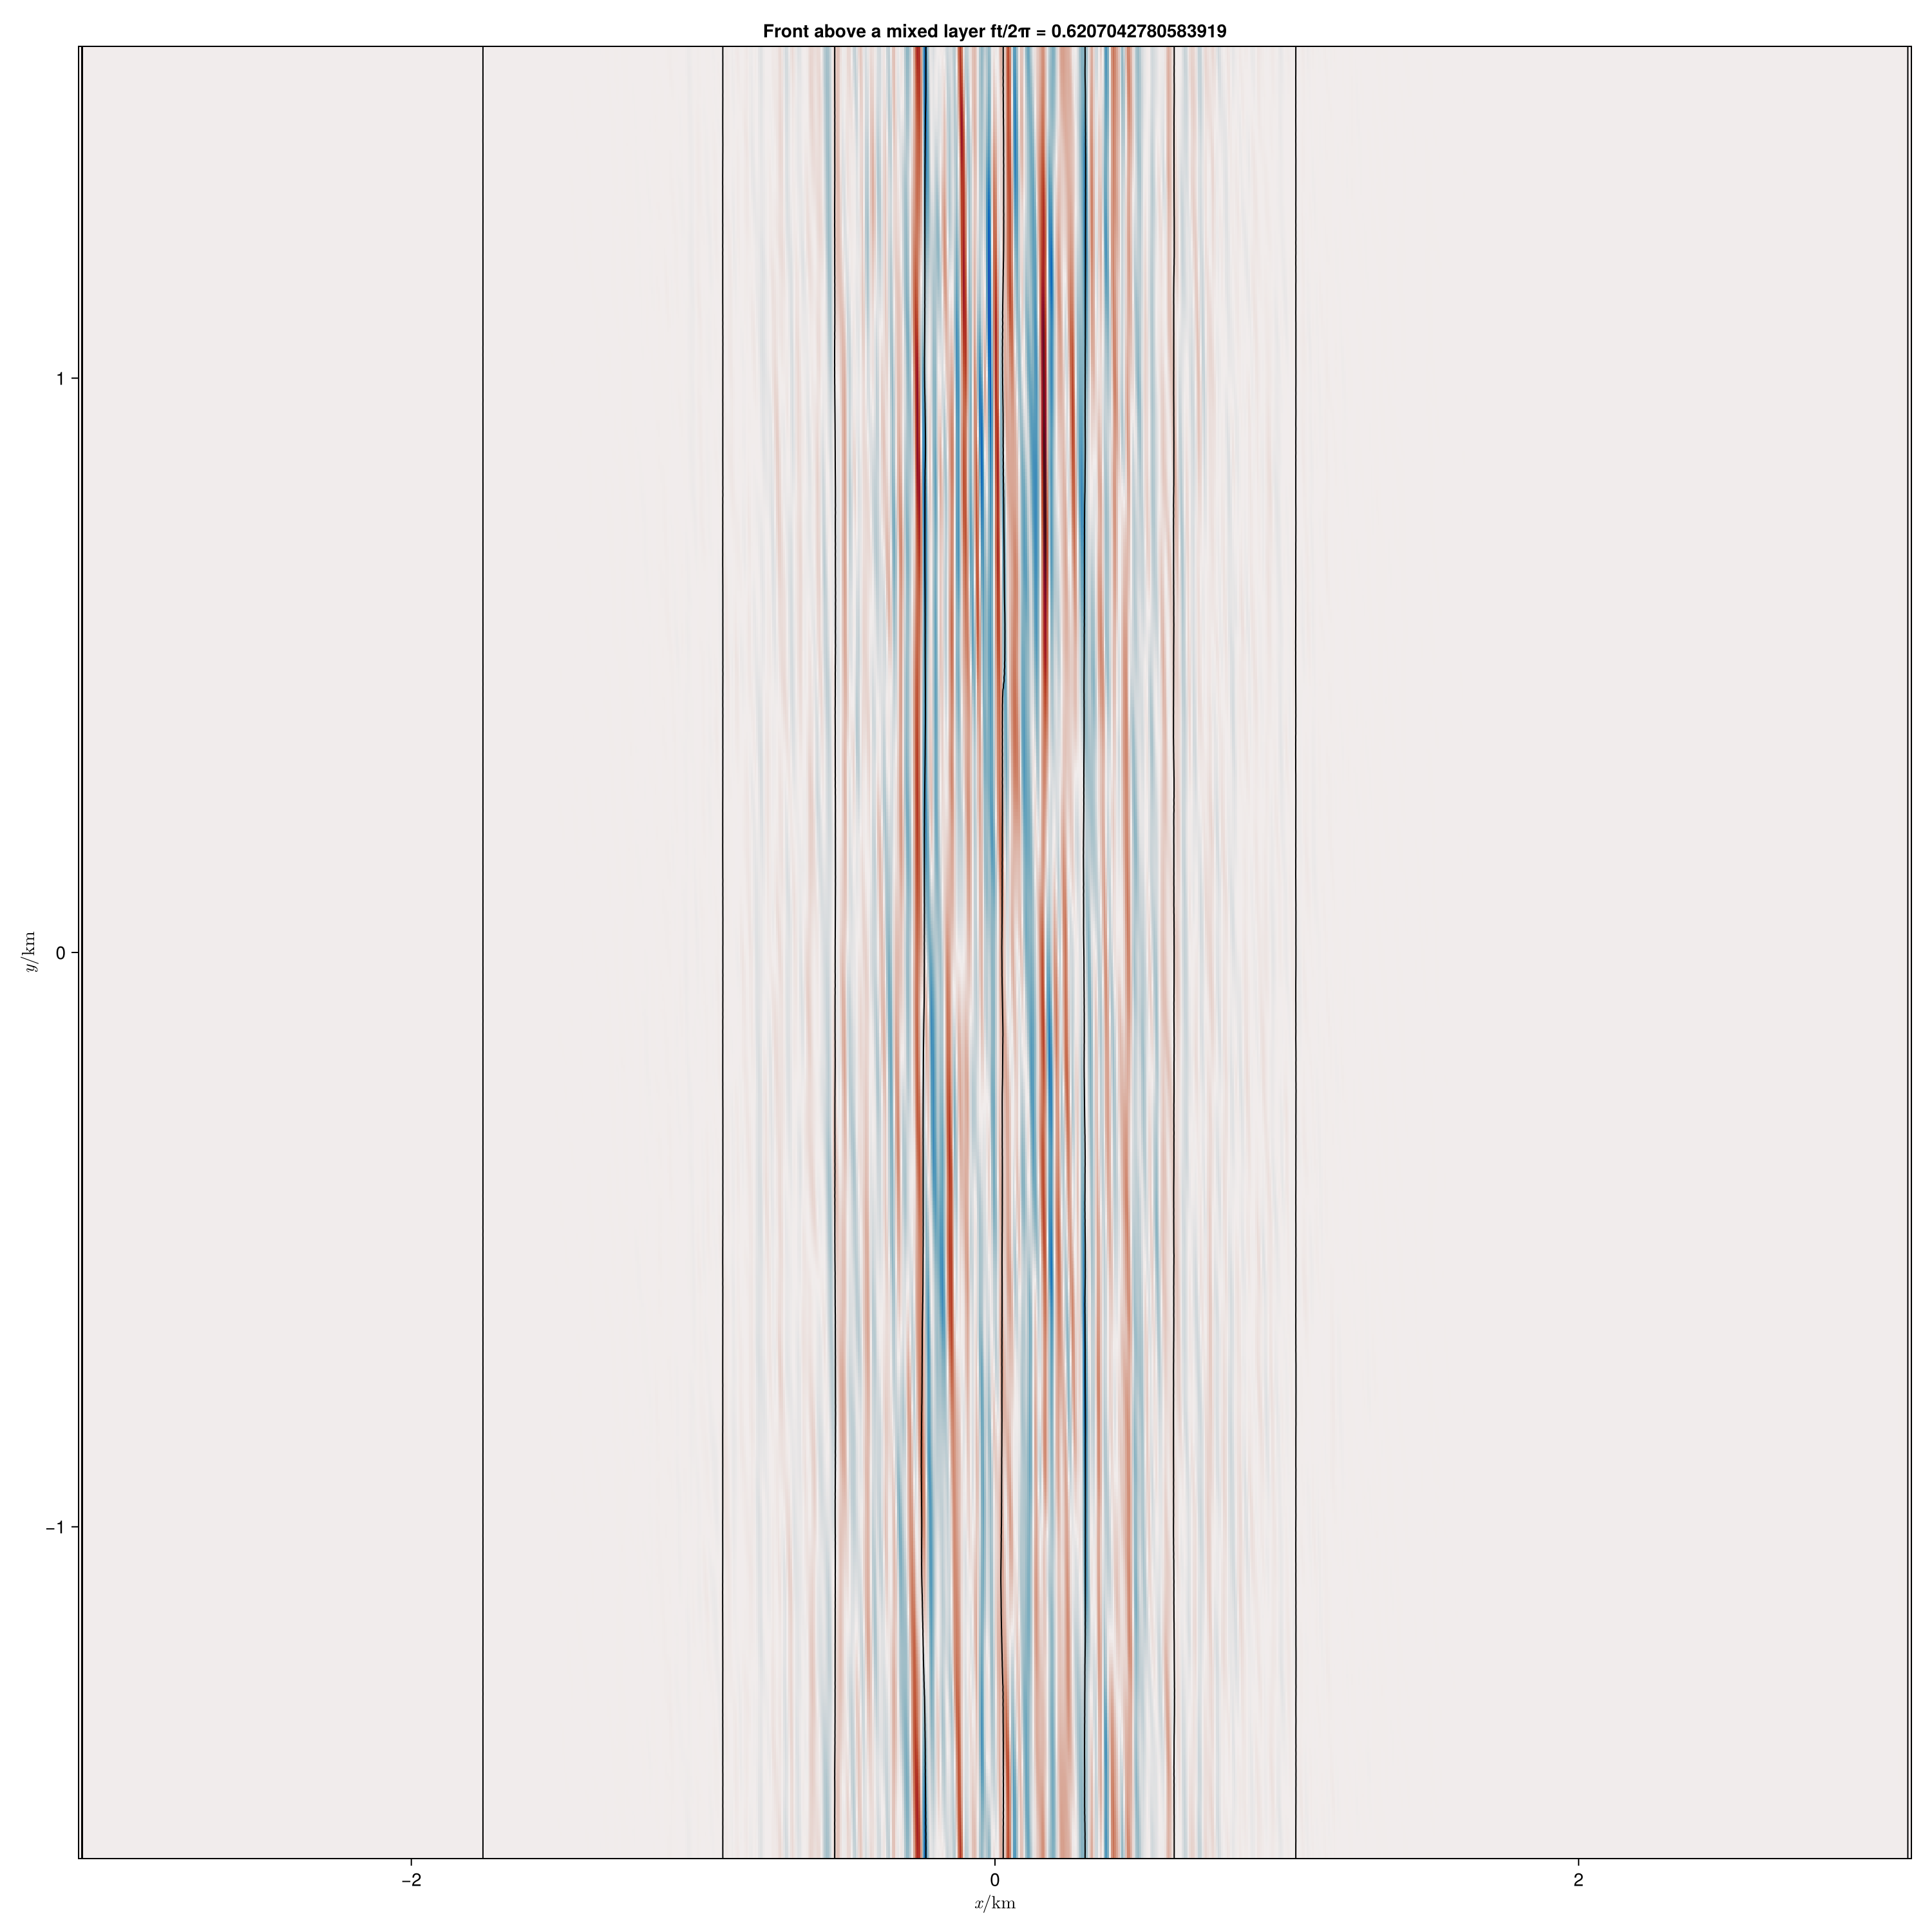

In [22]:
## Print simulation outputs
# Get a state of simulation
n = 40
foldername = "../../scratch/Project/NIechoes"

sp = jldopen("$foldername/parameters.jld2") do file
    file["simulation"]
end
filename = "$foldername/initialisation.jld2"
t, xs, ys, zs, u, v, w, b, φ = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"]
    ys = file["grid/yᵃᶜᵃ"]
    zs = file["grid/zᵃᵃᶜ"]
    u = (file["timeseries/u/$frame"][1:end-1, :, :] .+ file["timeseries/u/$frame"][2:end, :, :]) ./ 2
    v = (circshift(file["timeseries/v/$frame"], (0, -1, 0)) .+ circshift(file["timeseries/v/$frame"], (0, 1, 0))) ./ 2
    w = (file["timeseries/w/$frame"][:, :, 1:end-1] .+ file["timeseries/w/$frame"][:, :, 2:end]) ./ 2
    b = file["timeseries/b/$frame"]
    φ = file["timeseries/φ/$frame"]
    ts[n], xs, ys, zs, u, v, w, b, φ
    end;
fig = Figure(; size=(1500, 1500))
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"y / \text{km}", title="Front above a mixed layer ft/2π = $(sp.f * t/2π)", limits=(xs[1]/1000, xs[end]/1000, ys[1]/1000, ys[end]/1000))

b_levels = range(minimum(mean(b[4:end-3, :, 4:end-3]; dims=2)), maximum(mean(b[4:end-3, :, 4:end-3]; dims=2)), 10)

slice=96

field = w[:, :, slice]
#field = field .- imfilter(field, gaussian((64, 64)), "circular")
field = imfilter(field, gaussian((1, 1)), "circular")
println("Mean RMS $(sqrt(mean(mean(field; dims=2).^2)))")
println("Mean max $(maximum(abs, mean(field; dims=2)))")
println("Fluc RMS $(sqrt(mean((field .- mean(field; dims=2)).^2)))")
println("Fluc max $(maximum(abs, field .- mean(field; dims=2)))")
cmax= maximum(abs, field[14:end-17, 4:end-3])
heatmap!(ax, xs / 1000, ys / 1000, field; colormap=:balance, colorrange=(-cmax, cmax))
contour!(ax, xs / 1000, ys / 1000, b[:, :, slice]; color=:black, levels=b_levels)

fig

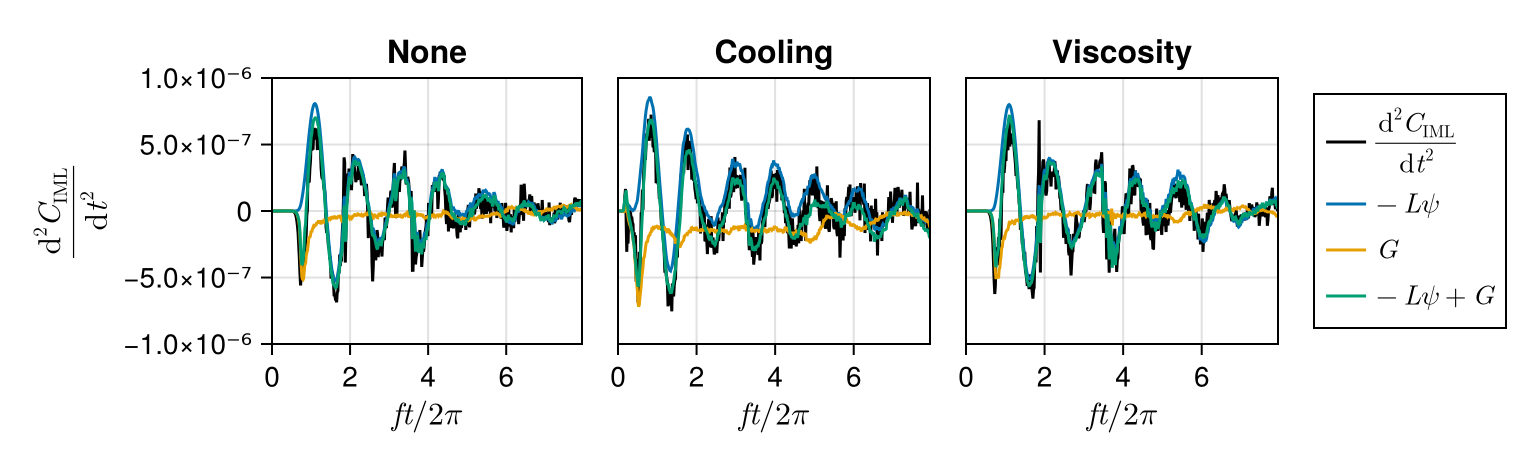

In [17]:
runnames = ["NIechoes", "NIechoes-Q", "NIechoes-Ek"]
foldernames = map(runnames) do runname
    "../../scratch/Project/$runname"
end
runlabels = ["None", "Cooling", "Viscosity"]
legendtitle = L"Ri";
b_levels = range(-0.002749, 0, 40)
ψ_levels = range(-1, 1, 12)
ψ_colors = [
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    RGB(1, 1, 1), 
    to_colormap(:PuOr)[1], 
    to_colormap(:PuOr)[1],
    to_colormap(:PuOr)[1]
]
VSP_colors = reverse(to_colormap(:curl))

fig = let foldernames = foldernames[1:3]
    fig = Figure(; size=(1000, 300)./1.3, fontsize=14)
    map(enumerate(foldernames)) do (i, foldername)
        # Get parameters 
        run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["run_time"], file["simulation"]
        end
        
        domain = (-sp.Lx/2, sp.Lx/2, -0.90sp.H, -0.1sp.H)
        
        # Compute the integrals
        ts, ∇²ψ_tt, Lψ = jldopen("$foldername/PSI_nice.jld2") do file
            iterations = keys(file["timeseries/t"])[2:end-1]
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            
            Δz = file["grid/Δzᵃᵃᶜ"]
            Δx = file["grid/Δxᶜᵃᵃ"]
            
            Ly = file["grid/Ly"]
            
            x_inds = domain[1] .< no_offset_view(file["grid/xᶜᵃᵃ"]) .< domain[2]
            z_inds = domain[3] .< no_offset_view(file["grid/zᵃᵃᶜ"]) .< domain[4]
            
            Lψ = map(iterations) do iteration
                a = no_offset_view(file["timeseries/Lψ/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            ∇²ψ_tt = map(iterations) do iteration
                a = no_offset_view(file["timeseries/∇²ψ_tt/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            ts, ∇²ψ_tt, Lψ
        end
        F_nl, F_other, F_VSP, F_BFLUX = jldopen("$foldername/PSI_notnice.jld2") do file
            iterations = keys(file["timeseries/t"])[2:end-1]
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            
            Δz = file["grid/Δzᵃᵃᶜ"]
            Δx = file["grid/Δxᶜᵃᵃ"]
            
            Ly = file["grid/Ly"]
            
            x_inds = domain[1] .< no_offset_view(file["grid/xᶜᵃᵃ"]) .< domain[2]
            z_inds = domain[3] .< no_offset_view(file["grid/zᵃᵃᶜ"]) .< domain[4]
            
            F_nl = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_nl/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_other = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_other/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_VSP = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_VSP/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_BFLUX = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_BFLUX/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_nl, F_other, F_VSP, F_BFLUX
        end
        
        # Plot
        ax = Axis(fig[1, i];
            xlabel=L"ft / 2\pi", 
            ylabel=L"\frac{\text{d}^2 C_{\text{IML}}}{\text{d}t^2}",
            title=runlabels[i],
            limits=(0, ts[end], -1e-6, 1e-6),
            xlabelsize=16, ylabelsize=16, titlesize=16
        )
        lns = [
            lines!(ax, ts, -∇²ψ_tt; color=:black),
            lines!(ax, ts, -Lψ),
            lines!(ax, ts, F_VSP + F_BFLUX + 0F_other),
            lines!(ax, ts, -Lψ + F_VSP + F_BFLUX + 0F_other)
        ]
        
        i != 1 && hideydecorations!(ax, grid=false)
        
        # Add a legend for the last one
        i == length(foldernames) && Legend(fig[1, i+1], lns, [L"\frac{\text{d}^2 C_{\text{IML}}}{\text{d}t^2}", L"-L\psi", L"G", L"-L\psi + G"])
        
    end
    fig
end
#save("../output/paper_figures/streamfunction_evolution_figure.png", fig; px_per_unit=2)
fig

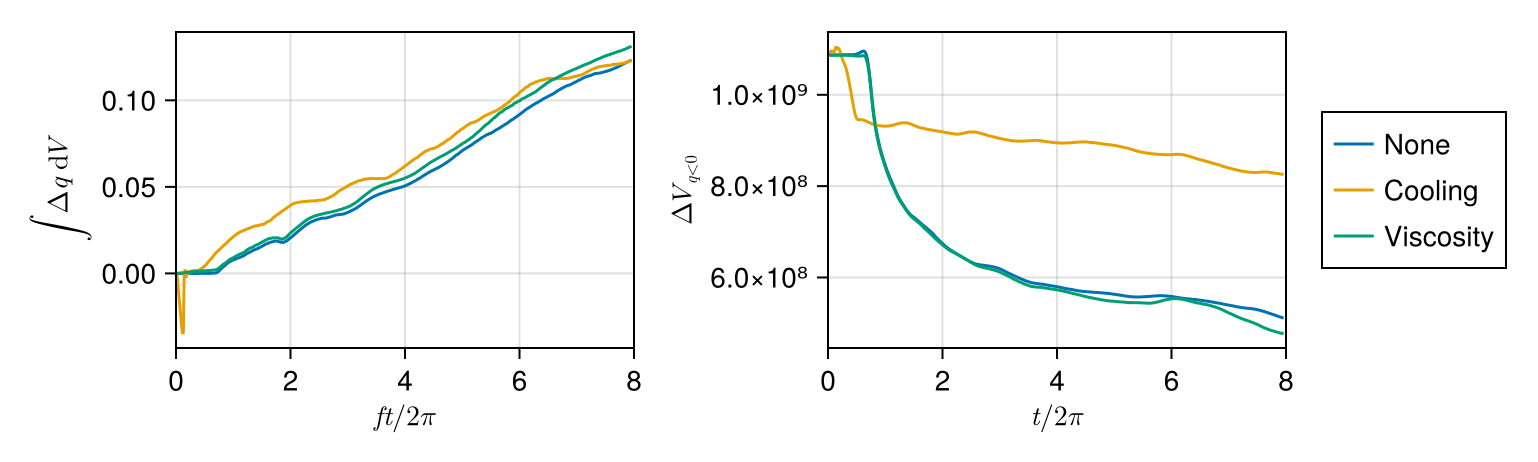

In [26]:
fig = let foldernames = foldernames[1:3]
    from_dfm = false
    fig = Figure(; size=(1000, 300)./1.3)
    # First figure is a plot of integrated PV
    ax = Axis(fig[1, 1]; xlabel=L"ft / 2\pi", ylabel=L"\int \Delta q \; \text{d}\!V", limits=((0, 8), nothing))
    lns = map(foldernames) do foldername
        run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["run_time"], file["simulation"]
        end
        
        ts, q = jldopen("$foldername/PV.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            init_iter = findfirst(ts .>= 0) + 1
            Δz = file["grid/Δzᵃᵃᶜ"]
            Ly = file["grid/Ly"] 
            Δx = file["grid/Δxᶜᵃᵃ"]
            q = map(iterations) do iteration
                sum(file["timeseries/q$(from_dfm ? "_from" : "")_dfm/$iteration"][1:sp.Nx, 1, 1:sp.Nz] .* Δz) * Δx * Ly
            end
            ts[init_iter:end], q[init_iter:end] .- q[init_iter]
        end
        lines!(ax, ts, q)
    end
    ax = Axis(fig[1, 2]; xlabel=L"t / 2\pi", ylabel=L"\Delta\! V_{q<0}", limits=((0, 8), nothing))
    # Second is the total volume of q<0 fluid
    lns = map(foldernames) do foldername
        run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["run_time"], file["simulation"]
        end
        
        ts, q_vol = jldopen("$foldername/PV.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            init_iter = findfirst(ts .>= 0) + 1
            q_vol = map(iterations) do iteration
                file["timeseries/q_vol$(from_dfm ? "_from_dfm" : "")/$iteration"][1]
            end
            ts[init_iter:end], q_vol[init_iter:end]# .- q_vol[init_iter]
        end
        lines!(ax, ts, q_vol)
    end
    Legend(fig[1, 3], lns, runlabels[1:3])
    fig
end
#save("../output/paper_figures/PV_figure.png", fig; px_per_unit=2)
fig

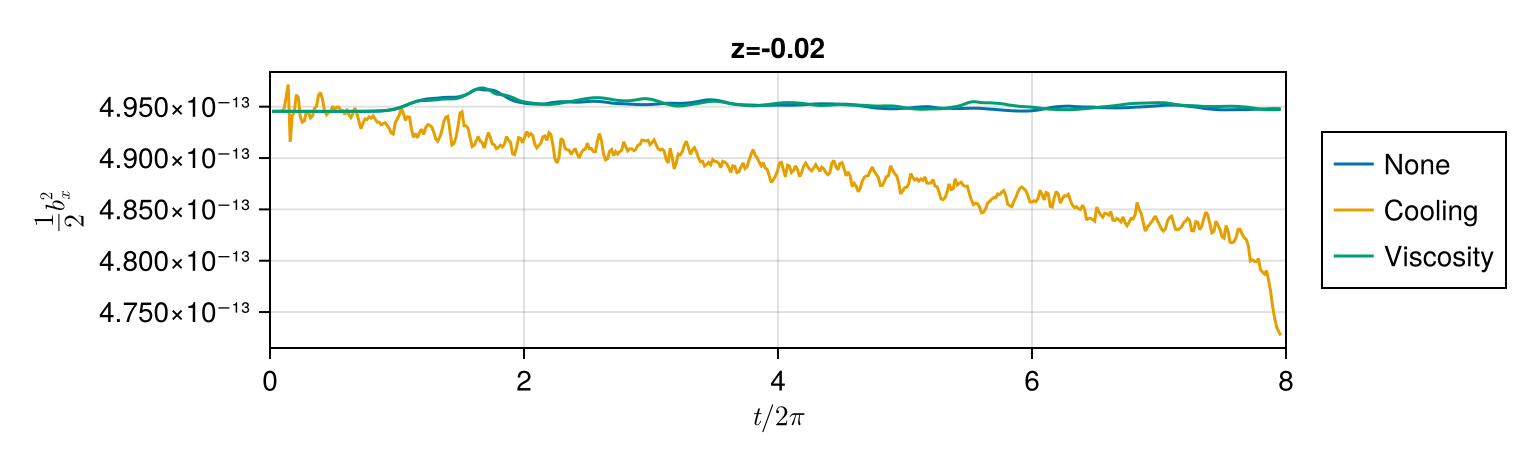

In [32]:
fig = let foldernames = foldernames[1:3]
    fig = Figure(; size=(1000, 300)./1.3)
    z = -0.02
    ax = Axis(fig[1, 1]; xlabel=L"t / 2\pi", ylabel=L"\frac{1}{2}b_x^2", limits=(0, 8, nothing, nothing), title="z=$z")
    lns = map(foldernames) do foldername
        run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["run_time"], file["simulation"]
        end
        ts, M² = jldopen("$foldername/DFM.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] * sp.f)/(2π), iterations)
            init_iter = findfirst(ts .>= 0) + 1
            zs = file["grid/zᵃᵃᶜ"]
            Δz = file["grid/Δzᵃᵃᶜ"]
            Ly = file["grid/Ly"] 
            Δx = file["grid/Δxᶜᵃᵃ"]
            M² = map(iterations) do iteration
                let a = imfilter(file["timeseries/b_dfm/$iteration"][1:sp.Nx, 1, argmin(abs.(zs .- z))], gaussian((10, )))
                    mean(((circshift(a, -1) - circshift(a, 1)) / (2Δx)).^2) / 2
                end
            end
            ts[init_iter:end], M²[init_iter:end]
        end
        lines!(ax, ts, M²)
    end
    Legend(fig[1, 2], lns, runlabels[1:3])
    fig
end
#save("../output/paper_figures/buoyancy_gradient_figure.png", fig; px_per_unit=2)
fig